In [2]:
%env CC=gcc-11
%env CXX=g++-11

env: CC=gcc-11
env: CXX=g++-11


## Intorduction

As in data analysis we first need to load the data and perform all the normalization and optimizations. The normalized data after all will be passed through PCA just to get only relavent features in the data. 

So let's start with data loading:

##### Normal data

In [3]:
import pandas

DATA = pandas.read_csv('../../../rnn/merged.csv')
DATA

,Counter(/clock),Mean_Consecutive(/clock),Counter(/host_diagnostic),Mean_Consecutive(/host_diagnostic),Counter(/joint_states),Mean_Consecutive(/joint_states),Counter(/kinect2/qhd/camera_info),Mean_Consecutive(/kinect2/qhd/camera_info),Counter(/kinect2/qhd/image_color/compressed),Mean_Consecutive(/kinect2/qhd/image_color/compressed),...,Threads(/move_base),MeanLoadCPU(/move_base),matansar(MinCPU0),matansar(StdCPU0),matansar(MinCPU1),matansar(StdCPU1),matansar(MinCPU2),matansar(StdCPU2),matansar(MinCPU3),matansar(StdCPU3)
0,416,0.001114,2,0.580318,35,0.021638,6,0.026784,3,0.045631,...,11.0,17.000000,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
1,920,0.001083,2,0.561588,46,0.021695,14,0.065842,10,0.105388,...,11.0,19.445455,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
2,905,0.001100,2,0.555192,45,0.022060,12,0.080915,9,0.112184,...,11.0,17.590000,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
3,934,0.001067,2,0.512376,47,0.021101,10,0.083380,9,0.105279,...,11.0,18.133333,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
4,941,0.001061,2,0.525791,47,0.021254,14,0.065183,10,0.105074,...,11.0,17.009091,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17870,980,0.001020,2,0.510422,49,0.019995,12,0.073625,10,0.103233,...,11.0,9.681818,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
17871,929,0.001076,2,0.553366,46,0.021433,14,0.073147,9,0.106950,...,11.0,9.666667,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
17872,953,0.001047,2,0.523317,48,0.020427,12,0.057224,10,0.104793,...,11.0,8.754546,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
17873,912,0.001091,2,0.561547,46,0.021688,12,0.079705,9,0.111040,...,11.0,8.610000,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18


##### Anomaly data

In [4]:
ANOMALY_DATA = pandas.read_csv('../../../rnn/merged_test.csv')
ANOMALY_DATA

,Counter(/clock),Mean_Consecutive(/clock),Counter(/host_diagnostic),Mean_Consecutive(/host_diagnostic),Counter(/joint_states),Mean_Consecutive(/joint_states),Counter(/kinect2/parameter_descriptions),Counter(/kinect2/parameter_updates),Counter(/kinect2/qhd/camera_info),Mean_Consecutive(/kinect2/qhd/camera_info),...,Threads(/move_base),MeanLoadCPU(/move_base),matansar(MinCPU0),matansar(StdCPU0),matansar(MinCPU1),matansar(StdCPU1),matansar(MinCPU2),matansar(StdCPU2),matansar(MinCPU3),matansar(StdCPU3)
0,469,0.001026,2,0.518104,34,0.020897,1,1,6,0.050149,...,11.0,11.820000,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
1,897,0.001115,2,0.550576,45,0.022322,0,0,12,0.071620,...,11.0,13.577778,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
2,865,0.001155,2,0.565974,43,0.023229,0,0,12,0.059923,...,11.0,11.910000,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
3,946,0.001051,2,0.530423,48,0.021028,0,0,14,0.073898,...,11.0,11.945455,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
4,949,0.001044,2,0.520119,48,0.021061,0,0,14,0.064801,...,11.0,11.488889,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,822,0.001080,1,0.000000,40,0.021743,0,0,12,0.068342,...,11.0,12.580000,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
1024,1027,0.000952,2,0.473058,51,0.019016,0,0,12,0.069623,...,11.0,15.580000,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
1025,917,0.001091,2,0.539508,46,0.021793,0,0,14,0.067429,...,11.0,17.455556,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
1026,841,0.001188,2,0.595000,42,0.023028,0,0,12,0.072452,...,11.0,15.320000,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18


For normalization we choose `MinMaxScaler` with value range between $\left[1, -1\right]$

In [5]:
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.stats import norm
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import os
from sklearn.decomposition import PCA
import datetime
from IPython.display import Image
import math

## Data processing

#### Data processing utils

In [6]:
scalers = {}

def normalize_data(original_data):
    """
    This function used for normalizing data, with MinMaxScaler.
    Each scaler saved in the external object for future use of de-transformation
    :param original_data: data from the file
    :return: normlized data in the same format as received
    """
    norm_data = original_data
    for i in original_data.columns:
        scaler = None
        if ('scaler_' + i) not in scalers:
            scaler = MinMaxScaler(feature_range=(-1, 1))
        else:
            scaler = scalers['scaler_' + i]
        s_s = scaler.fit_transform(norm_data[i].values.reshape(-1, 1))
        s_s = np.reshape(s_s, len(s_s))
        scalers['scaler_' + i] = scaler
        norm_data[i] = s_s
    return norm_data

def std_normalize_data(data):
    """
    This function used for normalizing data, with StandardScaler.
    Each scaler saved in the external object for future use of de-transformation
    :param original_data: data from the file
    :return: normlized data in the same format as received
    """
    norm_data = data
    for i in data.columns:
        scaler = None
        if ('scaler_' + i) not in scalers:
            scaler = MinMaxScaler(feature_range=(0, 1))
        else:
            scaler = scalers['scaler_' + i]
        s_s = scaler.fit_transform(norm_data[i].values.reshape(-1, 1))
        s_s = np.reshape(s_s, len(s_s))
        scalers['scaler_' + i] = scaler
        norm_data[i] = s_s
    return norm_data

def unnormalize_data(columns, reconstructed_data):
    """
    This function is normalization inverse function.
    :param columns: orinal columns names, used for taking correct scaler that was saved while normalization
    :param reconstructed_data: normalized data
    :return: unnormalized data 
    """
    restored_data = []
    for (i, name) in enumerate(columns):
        restored_data.append(np.array(scalers['scaler_' + name].inverse_transform(reconstructed_data[:,i].reshape(-1, 1))).flatten())
    return np.array(restored_data)


##### Choosing common columns

While looking on the data we saw that there are small difference in the columns of anomaly and normal data, so we tried to find common columns.

In [7]:
norm_data, columns = normalize_data(DATA.copy()).values, list(DATA.columns.values)

columns = DATA.columns
anomaly_columns = ANOMALY_DATA.columns
common_columns = np.intersect1d(columns, anomaly_columns)
common_columns = [x for _, x in sorted(zip(columns, common_columns), key=lambda pair: pair[0])]
anomaly_norm_data = normalize_data(ANOMALY_DATA.copy())[common_columns].values
print(anomaly_norm_data.shape)

(1028, 71)


#### Running PCA and taking only two columns

In [8]:
norm_data = normalize_data(DATA[common_columns].copy())
print('Original dataset shape:', norm_data.shape)
pca = PCA(n_components=0.9)
new_data = pca.fit_transform(norm_data)
n_pcs = pca.n_components_
most_important = [[np.abs(pca.components_[i]).argmax(), np.abs(pca.components_[i]).max()] for i in range(n_pcs)]
most_important = sorted(most_important , key=lambda a_entry: -a_entry[1])
most_important_data_fragment = pandas.DataFrame(most_important, columns=['Index of column', 'PCA coefficient'])
most_important_data_fragment

Original dataset shape: (17875, 71)


,Index of column,PCA coefficient
0,15,0.807374
1,30,0.769483
2,45,0.741393
3,59,0.718888
4,12,0.691078
5,23,0.656097
6,52,0.642728
7,54,0.629880
8,30,0.625120
9,16,0.555479


In [9]:
initial_feature_names = DATA.columns
most_important_column_names = [initial_feature_names[most_important[i][0]] for i in range(n_pcs)]
most_important_column_names_df = pandas.DataFrame(most_important_column_names, columns=['Column name'])
most_important_column_names_df

,Column name
0,Mean_Consecutive(/mobile_base_controller/odom)
1,Counter(/move_base/local_costmap/costmap)
2,Mean_Consecutive(/pan_tilt_trajectory_controll...
3,Threads(/twist_mux)
4,Counter(/mobile_base_controller/cmd_vel)
5,Mean_Consecutive(/move_base/TebLocalPlannerROS...
6,Counter(/scan)
7,Counter(/tf)
8,Counter(/move_base/local_costmap/costmap)
9,Counter(/move_base/NavfnROS/plan)


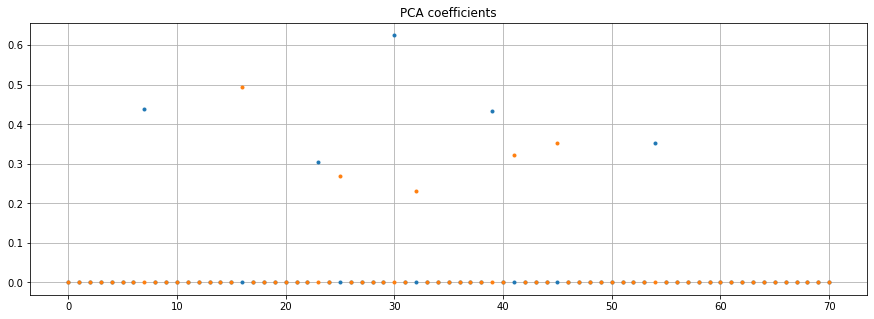

In [10]:
important_pca_comp = pca.components_[:2, :]
important_pca_comp = np.where(abs(important_pca_comp) <= 0.2, 0, important_pca_comp)
fig, axs = plt.subplots(1, figsize=(15, 5))
axs.plot(abs(important_pca_comp.T), ".")
axs.set_title('PCA coefficients')
plt.grid()
plt.show()
plt.close()

As the result of filtering we got only 10 points which mean that we have only 10 features of the original data will play major role in the linear transformation on the data we perform next.

##### Building linear combinations from important PCA components and original normilized data

So we took the list of components from the above plot and we multiply them by original and anomly normalized data as we show next: 

$$x = [x_1, x_2,...,x_{73}]\\$$
$$a = [0,0,0,..,a_n,0,..,a_k,0,...a_m,0...]\\\\
\tilde{y} = x \cdot a$$

(17875, 2)
(1028, 2)


Text(0.5, 1.0, 'Lineary transformed data')

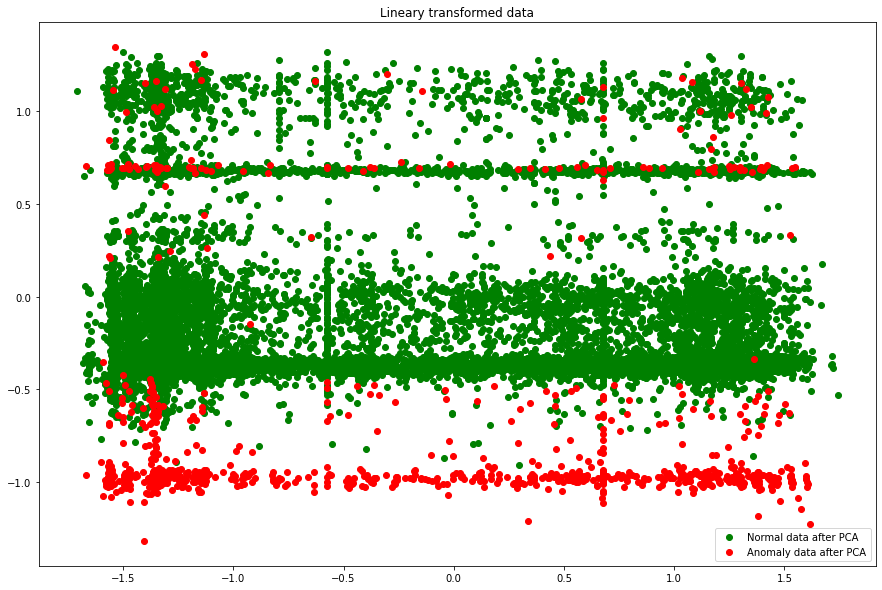

In [11]:
fig, axs = plt.subplots(1, figsize=(15, 10))
normal_pca_data = important_pca_comp.dot(norm_data.T).T
anomaly_pca_data = important_pca_comp.dot(anomaly_norm_data.T).T
print(normal_pca_data.shape)
print(anomaly_pca_data.shape)
axs.scatter(normal_pca_data[:,0], normal_pca_data[:,1], color="g", label="Normal data after PCA")
axs.scatter(anomaly_pca_data[:,0], anomaly_pca_data[:,1], color="r", label="Anomaly data after PCA")
axs.legend()
axs.set_title('Lineary transformed data')

In [12]:
normal_pca_data_df = pandas.DataFrame(normal_pca_data, columns=['y1', 'y2'])
normal_pca_data_df

,y1,y2
0,0.675685,-0.034512
1,1.435038,-0.259839
2,0.675685,0.040605
3,1.081021,-0.075067
4,1.416248,-0.317953
...,...,...
17870,0.641428,-0.347562
17871,0.953130,-0.399134
17872,1.397696,-0.365708
17873,1.177926,-0.341730


##### PCA Results plot 

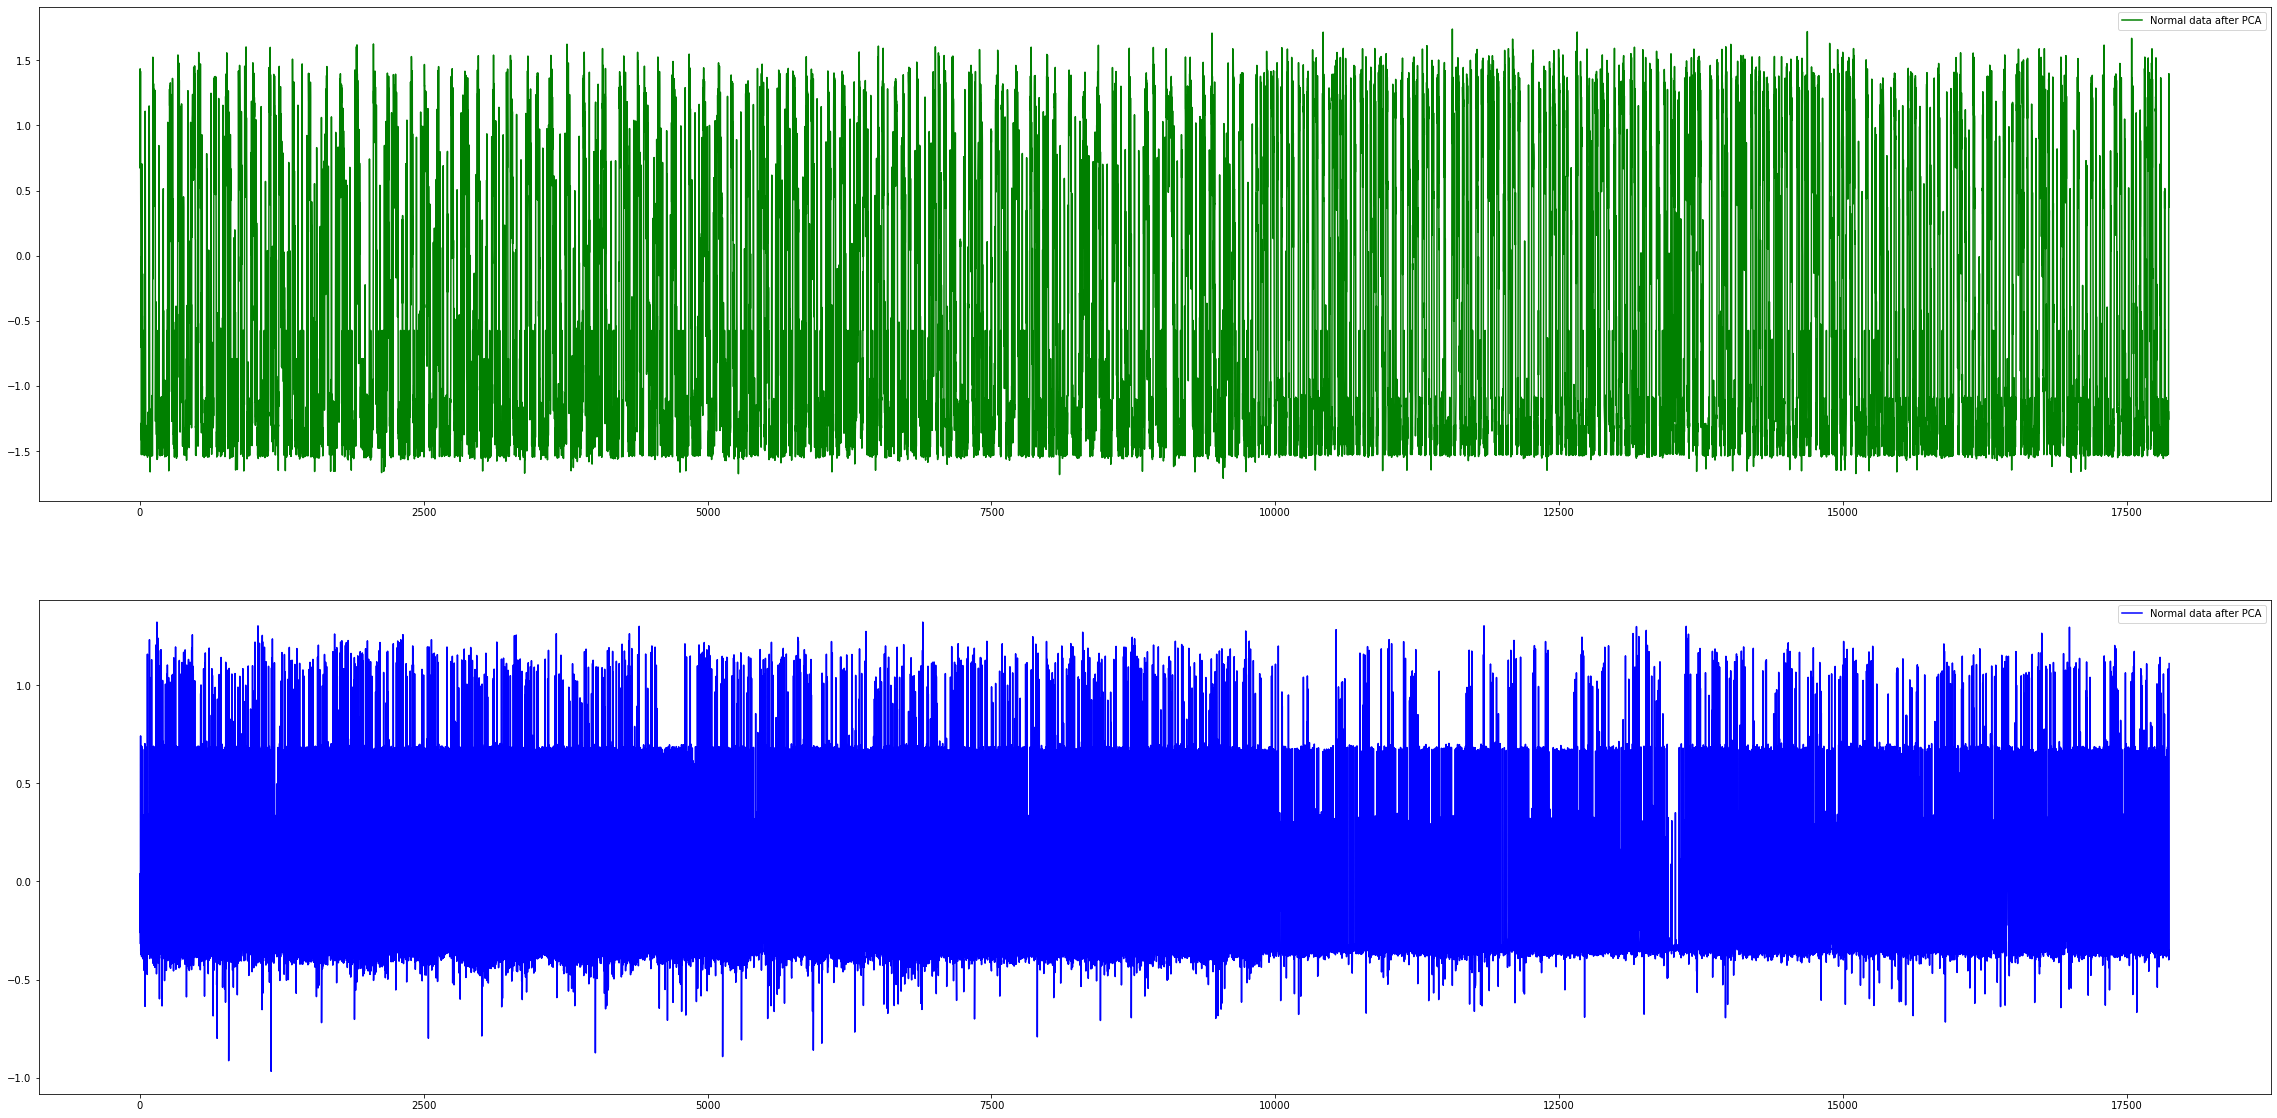

In [13]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(40, 20), squeeze=False)
axs[0][0].plot(range(len(normal_pca_data[:,0])), normal_pca_data[:,0], color="g", label="Normal data after PCA")
axs[1][0].plot(range(len(normal_pca_data[:,1])), normal_pca_data[:,1], color="b", label="Normal data after PCA")
axs[0][0].legend()
axs[1][0].legend()

Just to understand behaviour of the data we decided to plot histogram

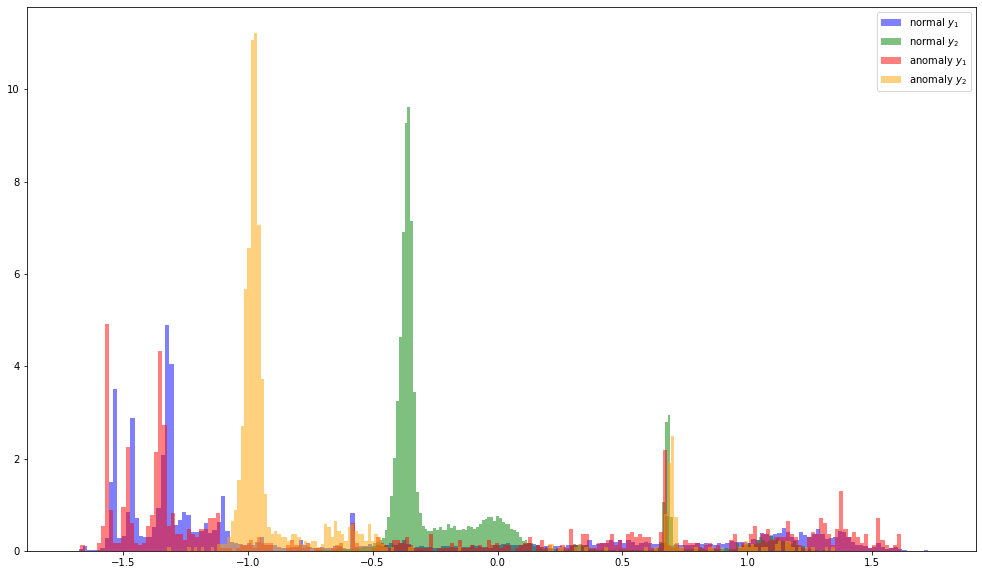

In [14]:
fig, axs = plt.subplots(1, figsize=(17, 10))
n, bins, patches = axs.hist(list(normal_pca_data[:, 0]), 200, facecolor='b', alpha=0.5, density=True, stacked=True, label="normal $y_1$")
n, bins, patches = axs.hist(list(normal_pca_data[:, 1]), 200, facecolor='g', alpha=0.5, density=True, stacked=True, label="normal $y_2$")
n, bins, patches = axs.hist(list(anomaly_pca_data[:, 0]), 200, facecolor='r', alpha=0.5, density=True, stacked=True, label="anomaly $y_1$")
n, bins, patches = axs.hist(list(anomaly_pca_data[:, 1]), 200, facecolor='orange', alpha=0.5, density=True, stacked=True, label="anomaly $y_2$")
axs.legend()

To see the results more clear we will normilize the data again to be in range between 0 and 1

## Model

Density estimation
DP-GMM or HDP



In [15]:
import pystan

In [127]:
GMM_MODEL = """
data {
    int<lower=0> N;            // Number of measurements
    vector[N] y;                 // Data
    int<lower=0> N_anomaly;
    vector[N_anomaly] y_anomaly; 
    
    int<lower=1> k;// Number of Gaussians

    real<lower=0> mu_loc_prior;
    real<lower=0> mu_shape_prior;
    real<lower=0> sigma_loc_prior;
    real<lower=0> sigma_shape_prior;

    real<lower=0> theta_loc_prior;
    real<lower=0> theta_scale_prior;
}
parameters {
    ordered[k] mu;
    real<lower=0> sigma[k];
    simplex[k] theta;
}
model {
    real ll[k];
    sigma ~ normal(sigma_loc_prior, sigma_shape_prior);
    mu ~ normal(mu_loc_prior, mu_shape_prior);
    theta ~ beta(theta_loc_prior, theta_scale_prior);
    
    for (n in 1:N) {
        for (i in 1:k) {
            ll[i] <- log(theta[i]) + normal_lpdf(y[n] | mu[k], sigma[k]);
        }
        increment_log_prob(log_sum_exp(ll));
    }       
}
"""

In [116]:
model = pystan.StanModel(model_code=GMM_MODEL, verbose=False, extra_compile_args=["-w"])

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_facb00075a6254fcc67fea1497c7e29e NOW.


In [117]:
stan_normal_data = normal_pca_data[:300]
stan_anomaly_data = anomaly_pca_data[:300]

In [120]:
mu_loc_prior = 0;
mu_shape_prior = 2;
sigma_loc_prior = 2;
sigma_shape_prior = 2;
theta_loc_prior = 2;
theta_scale_prior = 5;

faithful_data= {
    'N':stan_normal_data[:].shape[0],
    'y':stan_normal_data[:,0],
    'N_anomaly': stan_anomaly_data[:].shape[0],
    'y_anomaly': stan_anomaly_data[:,0],
    'k': 3,
    'mu_loc_prior': mu_loc_prior,
    'mu_shape_prior': mu_shape_prior,
    'sigma_loc_prior': sigma_loc_prior,
    'sigma_shape_prior': sigma_shape_prior,
    'theta_loc_prior': theta_loc_prior,
    'theta_scale_prior': theta_scale_prior
}
fit = model.sampling(data=faithful_data, iter=1000)
print(fit)

Inference for Stan model: anon_model_facb00075a6254fcc67fea1497c7e29e.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]     -2.63    0.04   1.01  -4.92  -3.28  -2.52  -1.86  -1.02    589   1.01
mu[2]     -1.44    0.02   0.64  -2.99  -1.82  -1.26  -0.94  -0.68   1104    1.0
mu[3]     -0.67  1.3e-3   0.06  -0.77  -0.71  -0.67  -0.63  -0.56   1729    1.0
sigma[1]   2.62    0.05   1.58   0.25   1.39   2.43   3.58   6.16    871    1.0
sigma[2]   2.61    0.06   1.55   0.09   1.45   2.48   3.65   5.84    634    1.0
sigma[3]   0.98  1.8e-3   0.04    0.9   0.95   0.98   1.01   1.06    495    1.0
theta[1]   0.33  5.5e-3   0.15   0.07   0.21   0.32   0.44   0.63    768    1.0
theta[2]   0.34  3.8e-3   0.15   0.07   0.23   0.33   0.44   0.65   1550    1.0
theta[3]   0.33  4.9e-3   0.15   0.08   0.22   0.32   0.43   0.63    894    1.0
lp__     -433

In [148]:
samples = fit.extract(permuted=True)
mu = samples['mu']
sigma = samples['sigma']
theta = samples['theta']
print(mu[0])
print(sigma[0])
print(theta[0])

[-3.3755935  -2.04387881 -0.62586261]
[3.06245102 3.91704414 0.97840525]
[0.212372   0.23568632 0.55194168]


In [163]:
def draw_from_GMM(mus, sigmas, thetas, lppd=False, y=0):
    numOfGaussians = len(mus)
    gmm_res = 0
    ppd_res = 1
    for i in range(numOfGaussians):
        gmm_res += thetas[i] * np.random.normal(mus[i], sigmas[i], size=1)[0]
    if lppd:
        for i in range(numOfGaussians):
            ppd_res += thetas[i] * norm.pdf(y, mus[i], sigmas[i])
            
    return gmm_res, ppd_res

In [170]:
def simulate_and_lppd(mu, sigma, theta, data, lppd=False):
    simulations = []
    lppds = []
    for am in data:
        sims, ppds = [], []
        for i in range(len(mu)):
            s, ppd = draw_from_GMM(mu[i], sigma[i], theta[i], lppd, am)
            sims.append(s)
            ppds.append(ppd)
        if lppd:
            lppds.append(math.log(np.average(ppds)))
#         rand_index = np.random.randint(len(sims))
#         simulations.append(sims[rand_index])
        simulations.append(np.mean(sims))
    return simulations, lppds

In [171]:
simulations, lppds = simulate_and_lppd(mu, sigma, theta, stan_anomaly_data[:,0], lppd=True)

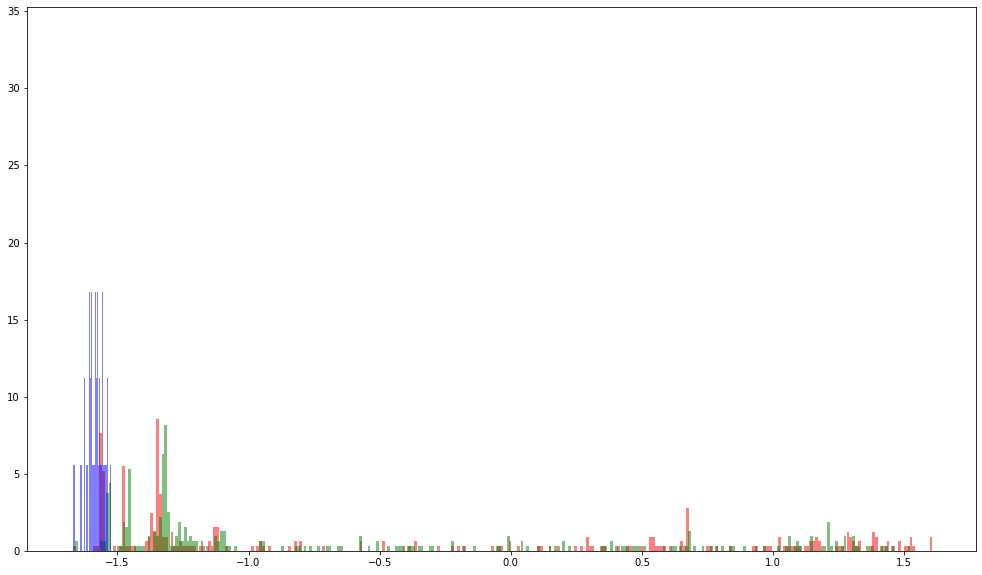

In [172]:
fig, axs = plt.subplots(1, figsize=(17, 10))
n, bins, patches = axs.hist(stan_anomaly_data[:,0], 300, facecolor='r', alpha=0.5, density=True, stacked=True, label="anomaly $y_1$")
n, bins, patches = axs.hist(stan_normal_data[:,0], 300, facecolor='g', alpha=0.5, density=True, stacked=True, label="normal $y_1$")
n, bins, patches = axs.hist(simulations, 300, facecolor='b', alpha=0.5, density=True, stacked=True, label="simulated $y_1$")
# # axs.plot(range(len(lppds)), lppds)
# mu = fit['mu']
# sigma = fit['sigma']


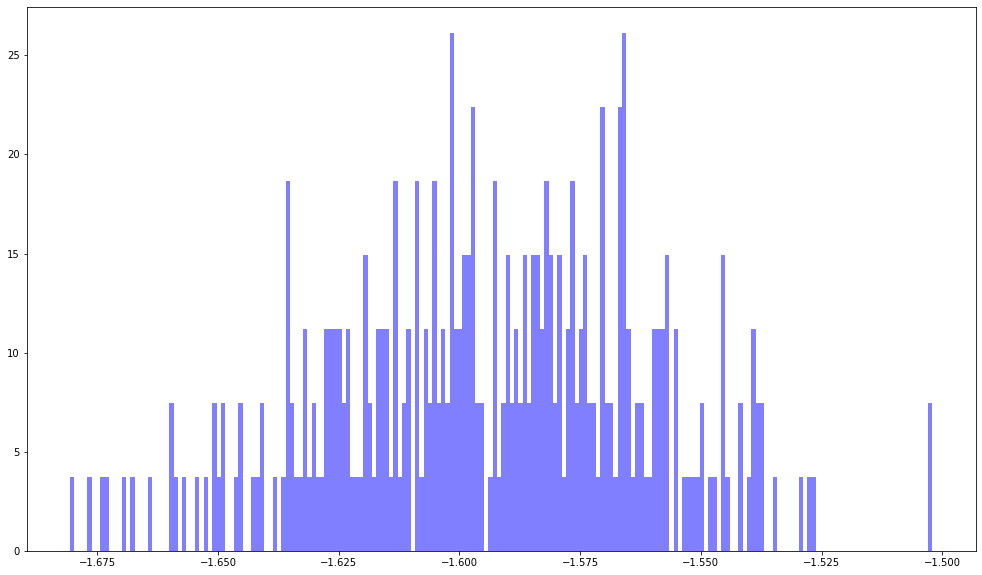

In [173]:
fig, axs = plt.subplots(1, figsize=(17, 10))
n, bins, patches = axs.hist(simulations, 200, facecolor='b', alpha=0.5, density=True, stacked=True, label="simulated $y_1$")


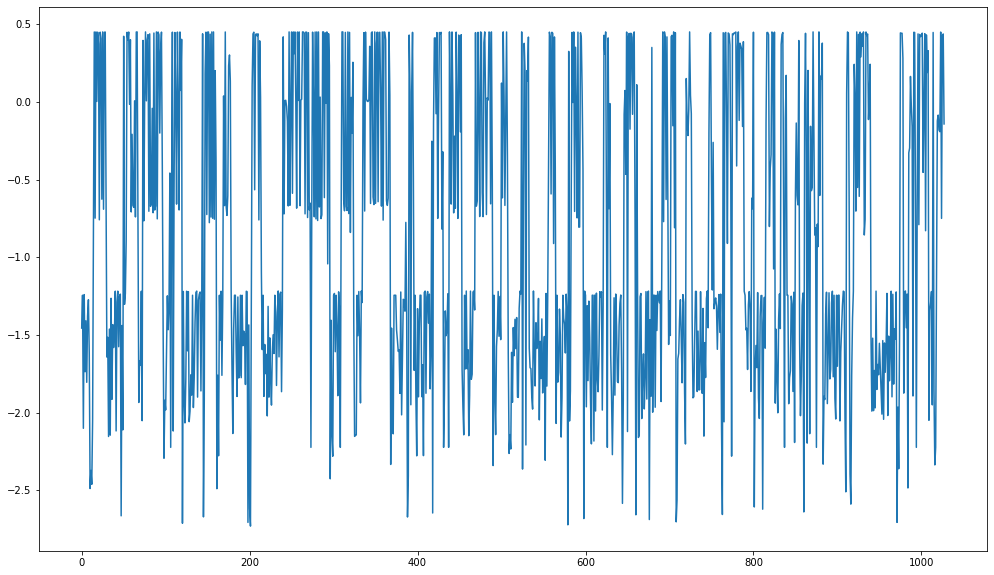

In [53]:
fig, axs = plt.subplots(1, figsize=(17, 10))
axs.plot(range(len(lppds)), lppds)

In [24]:
from scipy.stats import norm

mn = np.mean(mu, axis=0)
sg = np.mean(sigma, axis=0)
# theta
y_1 = norm(mn[0], sg[0])

fig, axs = plt.subplots(1, figsize=(17, 10))
n, bins, patches = axs.hist(list(normal_pca_data), 200, facecolor='b', alpha=0.5, density=True, stacked=True, label="normal $y_1$")
# print(bins)
plt.plot(bins, y_1.pdf(bins))
y_2 = norm(mn[1], sg[1])
plt.plot(bins, y_2.pdf(bins))



KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fd41d38a5f0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
# samples = fit.extract(permuted=True)
lppd = samples['lppd']

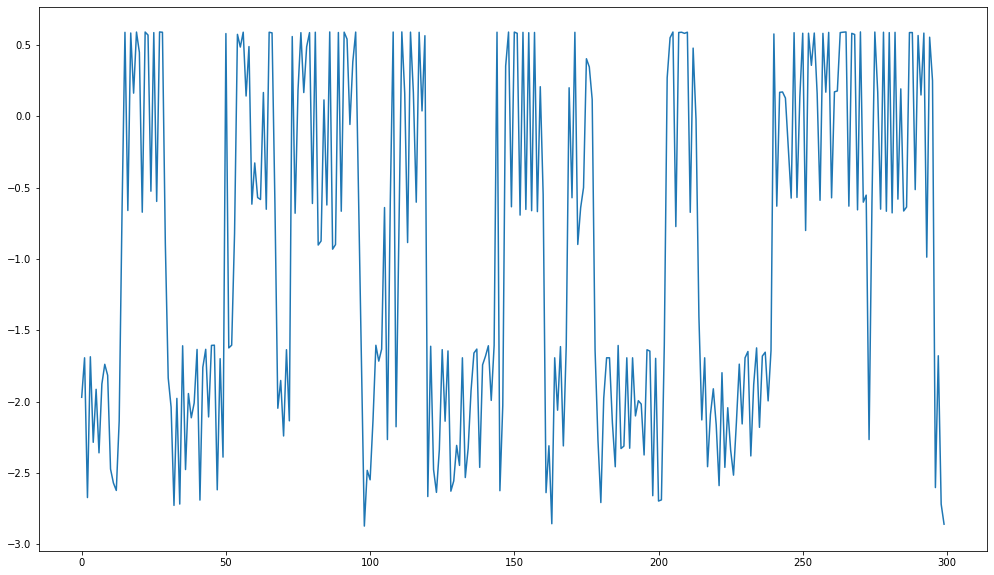

In [50]:
lppd_avg = np.average(lppd, axis=0)
fig, axs = plt.subplots(1, figsize=(17, 10))
plt.plot(range(len(lppd_avg)), lppd_avg)

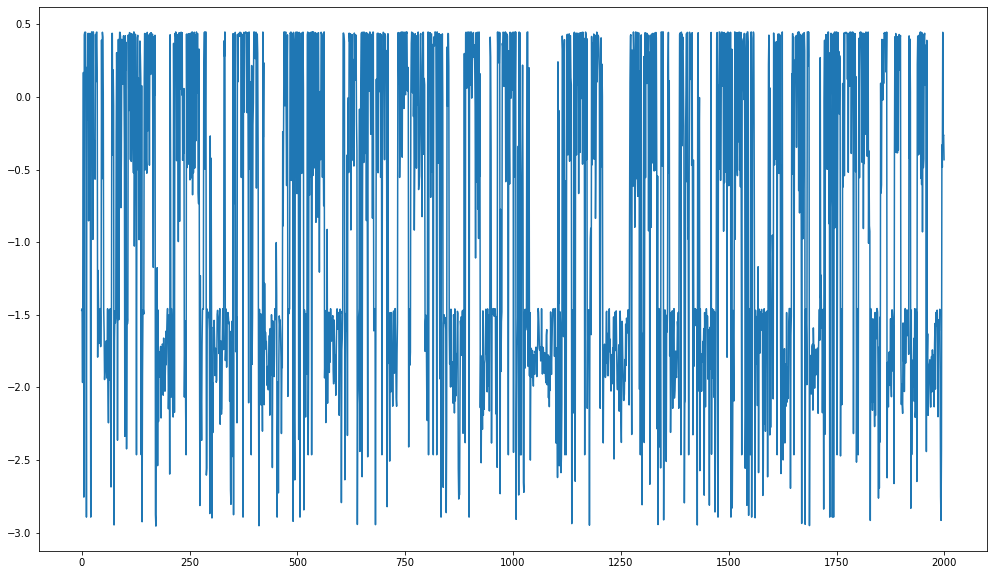

In [42]:
lppd_avg = np.average(lppd, axis=0)[8000:10000]
fig, axs = plt.subplots(1, figsize=(17, 10))
plt.plot(range(len(lppd_avg)), lppd_avg)

In [48]:
model = pystan.StanModel(model_code=GMM_MODEL)
faithful_data_y2={'N':normal_pca_data[:].shape[0],'y':normal_pca_data[:,1]}
fit_y2 = model.sampling(data=faithful_data_y2,iter=1000,warmup=100)
mu = fit['mu']
sigma = fit['sigma']

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6f3b097a7c01cdfe4323dfed8a6d9293 NOW.
cc1plus: warning: command-line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++
In file included from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1944,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /var/folders/pv/2l9q2qwd6hsccw9wc2zh8dzw0000gn/T/pystan_9ubu9brv/stanfit4anon_model_6f3b097a7c01cdfe4323dfed8a6d9293_2400717842910950631.cpp:709:
/Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API

In file included from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12,
                 from /var/folders/pv/2l9q2qwd6hsccw9wc2zh8dzw0000gn/T/pystan_9ubu9brv/stanfit4anon_model_6f3b097a7c01cdfe4323dfed8a6d9293_

In file included from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12,
                 from /var/folders/pv/2l9q2qwd6hsccw9wc2zh8dzw0000gn/T/pystan_9ubu9brv/stanfit4anon_model_6f3b097a7c01cdfe4323dfed8a6d9293_

In file included from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12,
                 from /var/folders/pv/2l9q2qwd6hsccw9wc2zh8dzw0000gn/T/pystan_9ubu9brv/stanfit4anon_model_6f3b097a7c01cdfe4323dfed8a6d9293_

In file included from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12,
                 from /var/folders/pv/2l9q2qwd6hsccw9wc2zh8dzw0000gn/T/pystan_9ubu9brv/stanfit4anon_model_6f3b097a7c01cdfe4323dfed8a6d9293_

In file included from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12,
                 from /var/folders/pv/2l9q2qwd6hsccw9wc2zh8dzw0000gn/T/pystan_9ubu9brv/stanfit4anon_model_6f3b097a7c01cdfe4323dfed8a6d9293_

In file included from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12,
                 from /var/folders/pv/2l9q2qwd6hsccw9wc2zh8dzw0000gn/T/pystan_9ubu9brv/stanfit4anon_model_6f3b097a7c01cdfe4323dfed8a6d9293_

In file included from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12,
                 from /var/folders/pv/2l9q2qwd6hsccw9wc2zh8dzw0000gn/T/pystan_9ubu9brv/stanfit4anon_model_6f3b097a7c01cdfe4323dfed8a6d9293_

In file included from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12,
                 from /var/folders/pv/2l9q2qwd6hsccw9wc2zh8dzw0000gn/T/pystan_9ubu9brv/stanfit4anon_model_6f3b097a7c01cdfe4323dfed8a6d9293_

In file included from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12,
                 from /var/folders/pv/2l9q2qwd6hsccw9wc2zh8dzw0000gn/T/pystan_9ubu9brv/stanfit4anon_model_6f3b097a7c01cdfe4323dfed8a6d9293_

In file included from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12,
                 from /var/folders/pv/2l9q2qwd6hsccw9wc2zh8dzw0000gn/T/pystan_9ubu9brv/stanfit4anon_model_6f3b097a7c01cdfe4323dfed8a6d9293_

In file included from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12,
                 from /var/folders/pv/2l9q2qwd6hsccw9wc2zh8dzw0000gn/T/pystan_9ubu9brv/stanfit4anon_model_6f3b097a7c01cdfe4323dfed8a6d9293_

In file included from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12,
                 from /var/folders/pv/2l9q2qwd6hsccw9wc2zh8dzw0000gn/T/pystan_9ubu9brv/stanfit4anon_model_6f3b097a7c01cdfe4323dfed8a6d9293_

In file included from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12,
                 from /var/folders/pv/2l9q2qwd6hsccw9wc2zh8dzw0000gn/T/pystan_9ubu9brv/stanfit4anon_model_6f3b097a7c01cdfe4323dfed8a6d9293_

In file included from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6,
                 from /Users/igorvinokur/anaconda3/envs/stanenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12,
                 from /var/folders/pv/2l9q2qwd6hsccw9wc2zh8dzw0000gn/T/pystan_9ubu9brv/stanfit4anon_model_6f3b097a7c01cdfe4323dfed8a6d9293_

ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: dylib (/usr/local/Cellar/gcc/11.2.0/lib/gcc/11/libstdc++.dylib) was built for newer macOS version (11.3) than being linked (10.9)
ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: dylib (/usr/local/Cellar/gcc/11.2.0/lib/gcc/11/libstdc++.dylib) was built for newer macOS version (11.3) than being linked (10.9)



Gradient evaluation took 0.006204 seconds
1000 transitions using 10 leapfrog steps per transition would take 62.04 seconds.
Adjust your expectations accordingly!


         three stages of adaptation as currently configured.
         Reducing each adaptation stage to 15%/75%/10% of
         the given number of warmup iterations:
           init_buffer = 15
           adapt_window = 75
           term_buffer = 10


Gradient evaluation took 0.006011 seconds
1000 transitions using 10 leapfrog steps per transition would take 60.11 seconds.
Adjust your expectations accordingly!


         three stages of adaptation as currently configured.
         Reducing each adaptation stage to 15%/75%/10% of
         the given number of warmup iterations:
           init_buffer = 15
           adapt_window = 75
           term_buffer = 10


Gradient evaluation took 0.006311 seconds
1000 transitions using 10 leapfrog steps per transition would take 63.11 seconds.
Adjust your expectations accordingly!



Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 16)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 16)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the 

Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 101 / 1000 [ 10%]  (Sampling)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 101 / 1000 [ 10%]  (Sampling)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 101 / 1000 [ 10%]  (Sampling)
Iteration: 200 / 1000 [ 20%]  (Sampling)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 101 / 1000 [ 10%]  (Sampling)
Iteration: 300 / 1000 [ 30%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Sampling)
Iteration: 200 / 1000 [ 20%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 300 / 1000 [ 30%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 3.70649 seconds (Warm-up)
               29.3163 seconds (Sampling)
               33.0228 seconds (Total)

Iteration: 400 / 1000 [ 40%]  (Sampling)
Iteration: 200 / 1000 [ 20%]  (Sampling)
Iteration: 500 / 1000 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


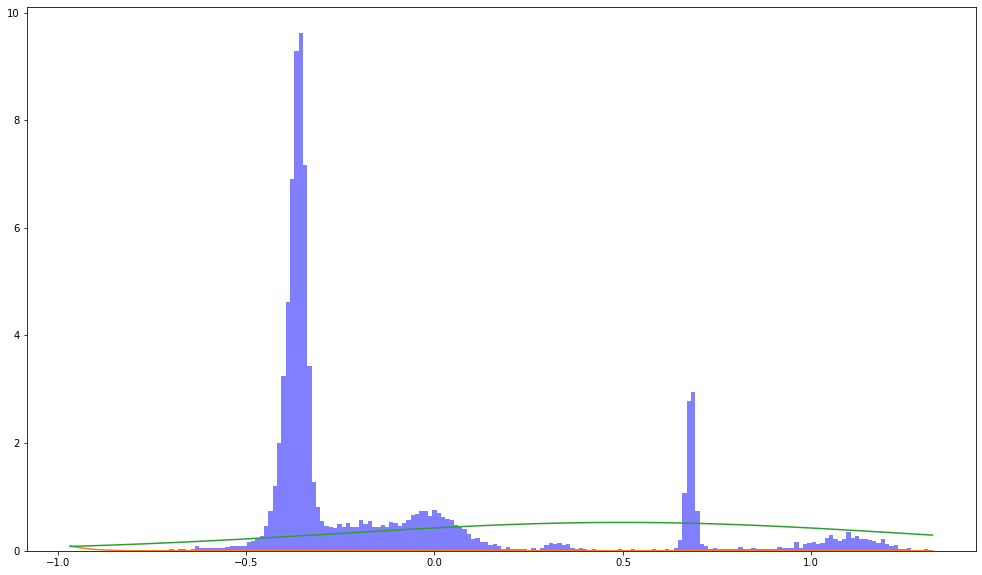

In [49]:
mn = np.mean(mu, axis=0)
sg = np.mean(sigma, axis=0)

y_1 = norm(mn[0], sg[0])

fig, axs = plt.subplots(1, figsize=(17, 10))
n, bins, patches = axs.hist(list(normal_pca_data[:, 1]), 200, facecolor='b', alpha=0.5, density=True, stacked=True, label="normal $y_1$")
plt.plot(bins, y_1.pdf(bins))
y_2 = norm(mn[1], sg[1])
plt.plot(bins, y_2.pdf(bins))

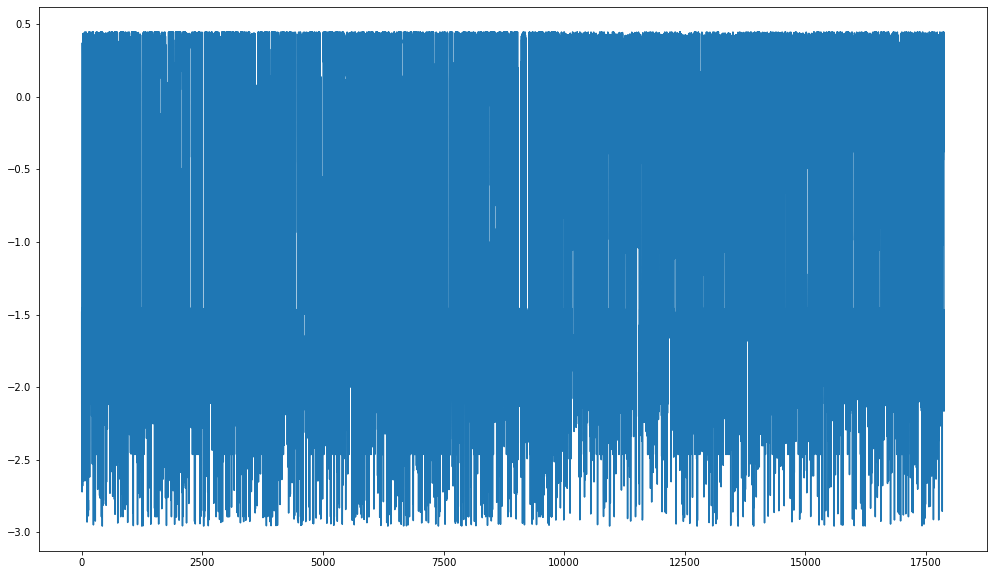

In [50]:
samples = fit.extract(permuted=True)
lppd_2 = samples['lppd']
lppd_avg = np.average(lppd_2, axis=0)
fig, axs = plt.subplots(1, figsize=(17, 10))
plt.plot(range(len(lppd_avg)), lppd_avg)

Try 2,3,4,5 Gaussians

Posterior sampling

2-d GMM

ARVIZ - https://arviz-devs.github.io/arviz/